<a href="https://colab.research.google.com/github/DyatlovaA/IOSU-2023/blob/master/CV_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа №2 тему "Автокодировщик для удаления шума с изображений"
Выполнили студенты Першуков Н.Д. и Елфимов К.Д., гр. АДИИ-24.

## Цель работы  
Используя TensorFLow, реализовать свою модель НС, которая решает задачу удаления шума с изображения. Необходимо выбрать dataset, выполнить предобработку данных, построить модель, обучить её, провести тесты, достигнуть необходимой целевой точности.

## Введение

**Задача** удаления шума с изображения.

**Датасет**: https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization?resource=download

## Ход работы

In [ ]:
! gdown 1x9ImHnBEvTbIPwotPbZxIDGlX6ENMjpX

Downloading...
From (original): https://drive.google.com/uc?id=1x9ImHnBEvTbIPwotPbZxIDGlX6ENMjpX
From (redirected): https://drive.google.com/uc?id=1x9ImHnBEvTbIPwotPbZxIDGlX6ENMjpX&confirm=t&uuid=58e77475-558a-4226-868d-e68f78486254
To: /content/landscape.zip
100% 201M/201M [00:04<00:00, 44.3MB/s]


In [ ]:
!unzip '/content/landscape.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: l

## Предобработка данных

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, Flatten, Dense, Reshape, Dropout, BatchNormalization, Conv2DTranspose, GlobalAveragePooling2D, ReLU
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
from glob import glob
import math

In [ ]:
BATCH_SIZE = 16
IMG_HEIGHT = 224
IMG_WIDTH = 224
NOISE_FACTOR = 0.4
EPOCHS = 50
DATA_DIR = '/content/landscape Images/color'

In [ ]:
class MyDatasetSequence(tf.keras.utils.Sequence):
    def __init__(self, image_paths, batch_size, img_size, noise_factor):
        super().__init__()
        self.image_paths = image_paths
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor
        self.indexes = np.arange(len(self.image_paths))
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """Возвращает кортеж из (noisy_images, original_images)"""
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images = np.array([self._load_image(self.image_paths[i]) for i in batch_indexes])
        noisy_images = self.add_gaussian_noise(images)
        return noisy_images, images

    def _load_image(self, path):
        """Загружает и нормализует изображение"""
        img = load_img(path, target_size=self.img_size)
        return img_to_array(img) / 255.0  # Нормализация в [0, 1]

    def add_gaussian_noise(self, images):
        """Векторизованное добавление шума"""
        noise = np.random.normal(loc=0, scale=self.noise_factor, size=images.shape)
        return np.clip(images + noise, 0., 1.)

    def __iter__(self):
        """Позволяет итерироваться по датасету"""
        for i in range(len(self)):
            yield self[i]

class MyDataset:
    def __init__(
            self,
            image_path,
            batch_size=BATCH_SIZE,
            img_size=(IMG_HEIGHT, IMG_WIDTH),
            noise_factor=NOISE_FACTOR,
            train_split=0.7,
            valid_split=0.2,
            test_split=0.1
        ):
        """Создает три датасета: train, valid, test в заданных пропорциях"""
        assert math.isclose(0.7 + 0.2 + 0.1, 1.0), "Сумма train, valid, test должна быть 1"

        self.image_paths = self._get_image_paths(image_path)
        self.batch_size = batch_size
        self.img_size = img_size
        self.noise_factor = noise_factor

        # Разделение данных на train, valid, test
        random.seed(42)
        random.shuffle(self.image_paths)

        train_size = int(len(self.image_paths) * train_split)
        valid_size = int(len(self.image_paths) * valid_split)

        self.data_splits = {
            'train': MyDatasetSequence(self.image_paths[:train_size], self.batch_size, self.img_size, self.noise_factor),
            'valid': MyDatasetSequence(self.image_paths[train_size:train_size + valid_size], self.batch_size, self.img_size, self.noise_factor),
            'test': MyDatasetSequence(self.image_paths[train_size + valid_size:], self.batch_size, self.img_size, self.noise_factor)
        }

    def _get_image_paths(self, folder):
        """Читает все пути к изображениям в указанной папке"""
        exts = ('*.jpg', '*.jpeg', '*.png')  # Разрешённые расширения
        image_paths = []
        for ext in exts:
            image_paths.extend(glob(os.path.join(folder, ext)))
        if not image_paths:
            raise ValueError(f"Не найдено изображений в папке: {folder}")
        return sorted(image_paths)  # Сортируем для стабильности порядка

    def __getitem__(self, split):
        """Возвращает объект класса Sequence для train/valid/test"""
        if split not in self.data_splits:
            raise KeyError(f"Доступны только ключи: {list(self.data_splits.keys())}")
        return self.data_splits[split]

In [ ]:
data = MyDataset(DATA_DIR)

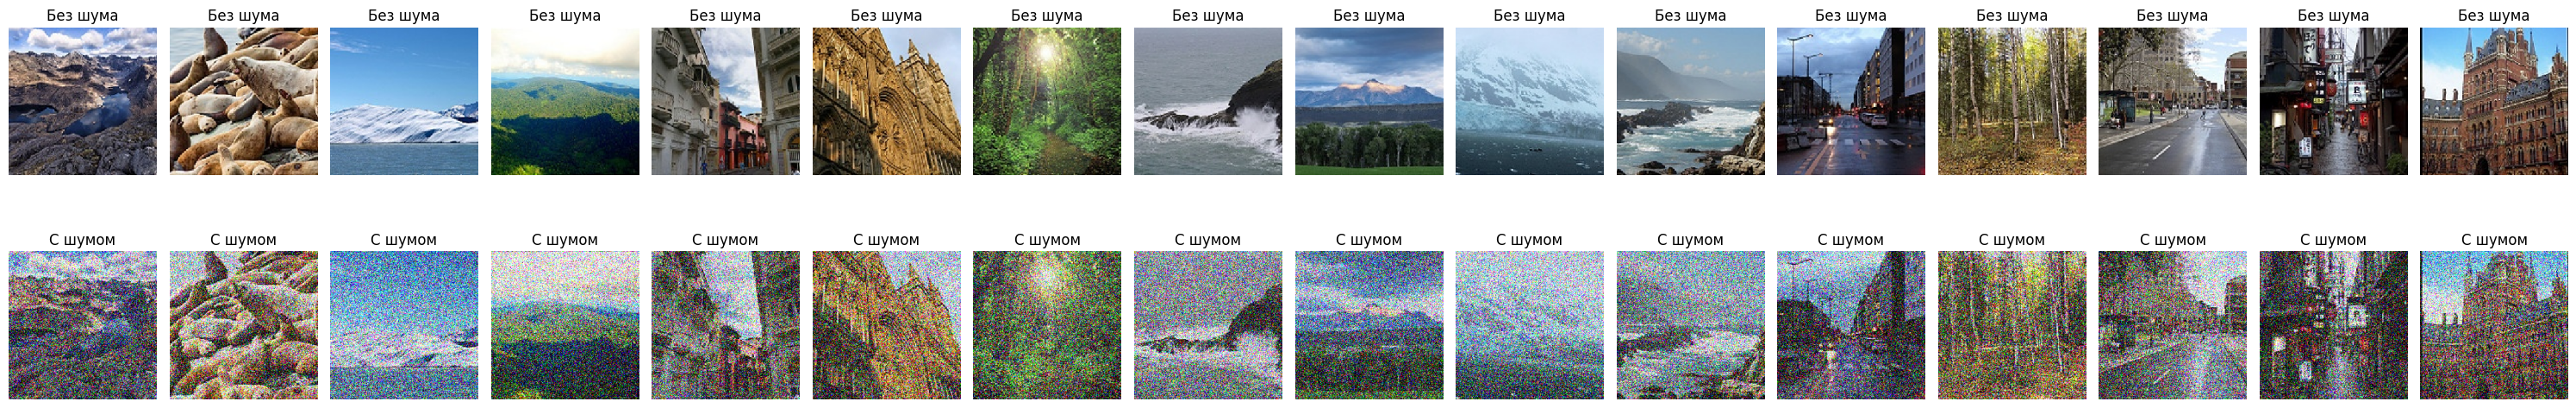

In [ ]:
# Визуализация изображений
for noisy_images, original_images in data.data_splits['train']:
    fig, ax = plt.subplots(nrows=2, ncols=len(noisy_images), figsize=(30, 6))

    for idx in range(len(noisy_images)):
        original_image = original_images[idx]  # Получаем оригинальное изображение
        noisy_image = noisy_images[idx]

        # Отображаем оригинальное изображение
        ax[0, idx].imshow(original_image)
        ax[0, idx].axis('off')
        ax[0, idx].set_title('Без шума')

        # Отображаем шумное изображение
        ax[1, idx].imshow(noisy_image)
        ax[1, idx].axis('off')
        ax[1, idx].set_title('С шумом')

    plt.tight_layout()
    plt.show()
    break

In [ ]:
# Создаем учебные и валидационные наборы
train_data = data.data_splits['train']
val_data = data.data_splits['valid']
test_data = data.data_splits['test']

In [ ]:
# Функция для отображения изображений
def display_images(noisy, original, reconstructed, num_images=5):
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # Отображаем оригинальное изображение
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(original[i])
        plt.title("Original")
        plt.axis('off')

        # Отображаем зашумленное изображение
        plt.subplot(3, num_images, i + 1)
        plt.imshow(noisy[i])
        plt.title("Noisy")
        plt.axis('off')

        # Отображаем восстановленное изображение
        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

In [ ]:
def add_salt_pepper(original_image_batch, noise_factor):
    if noise_factor - 1.0 > 0.0 or noise_factor < 0.0:
        raise ValueError('Передайте noise_factor от 0 до 1!')

    noisy_images = []
    for original_image in original_image_batch:
        noisy_image = original_image.copy()
        h, w, c = original_image.shape
        num_pixels = h * w
        num_noisy = int(noise_factor * num_pixels)
        num_salt, num_pepper = num_noisy // 2,  num_noisy - num_noisy // 2

        coords = np.arange(num_pixels)
        np.random.shuffle(coords)
        salt_idxs = coords[:num_salt]
        pepper_idxs = coords[num_salt:(num_salt + num_pepper)]

        salt_coords = np.unravel_index(salt_idxs, (h, w))
        pepper_coords = np.unravel_index(pepper_idxs, (h, w))

        noisy_image[pepper_coords[0], pepper_coords[1], :] = 1.0
        noisy_image[pepper_coords[0], pepper_coords[1], :] = 0.0
        noisy_images.append(noisy_image)

    return np.array(noisy_images)

In [ ]:
def model_rate(origin_images, reconstructed_images) -> dict:
    psnr_values = []
    ssim_values = []

    for origin, reconstructed in list(zip(o_images, r_images)):
        psnr_values.append(psnr(origin, reconstructed, data_range=1.0))
        ssim_values.append(ssim(origin, reconstructed, multichannel=True, channel_axis=2, data_range=1.0))

    mean_psnr = np.mean(psnr_values)
    mean_ssim = np.mean(ssim_values)
    return {'mean_psnr': mean_psnr, 'mean_ssim': mean_ssim}

# 1. Автоэнкодер 1

## 1.1 Создание модели

In [ ]:
def create_autoencoder_1(input_shape):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((4, 4))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D(size=(4, 4))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    return autoencoder

In [ ]:
autoencoder = create_autoencoder_1(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 56, 56, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 56, 56, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 64)        │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 224, 224, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 224, 224, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,308,995 (4.99 MB)

 Trainable params: 1,307,203 (4.99 MB)

 Non-trainable params: 1,792 (7.00 KB)

## 1.2 Обучение модели

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 433s 1s/step - loss: 0.0204 - val_loss: 0.0547
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 891ms/step - loss: 0.0108 - val_loss: 0.0148
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 891ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 294s 942ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 892ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 891ms/step - loss: 0.0083 - val_loss: 0.0112
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 891ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 890ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 890ms/step - loss: 0.0074 - val_loss: 0.0078
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 890ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 278s 891ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 12/50

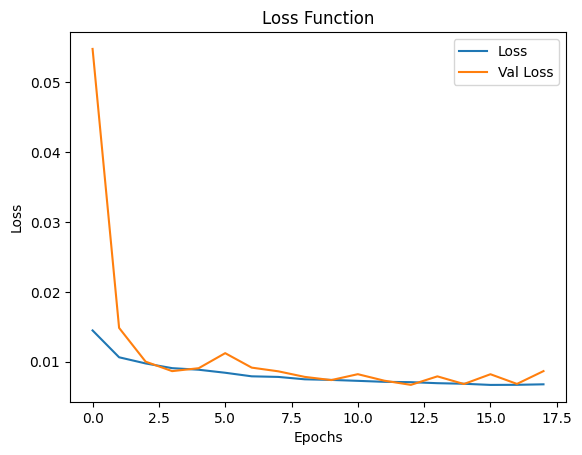

In [ ]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = autoencoder.fit(train_data, validation_data=val_data,
                          epochs=EPOCHS, batch_size=BATCH_SIZE,
                          callbacks=[early_stopping], verbose=1)

# Визуализация потерь
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
source_path = '/content/CV_2_1.keras'
autoencoder.save(source_path)

## 1.3 Тесты


In [ ]:
! gdown 1JjcXwOf_aPp309JYEhPTgY7yt8oIplI0

Downloading...
From: https://drive.google.com/uc?id=1JjcXwOf_aPp309JYEhPTgY7yt8oIplI0
To: /content/CV_2_1.keras
100% 15.2M/15.2M [00:00<00:00, 27.1MB/s]


In [ ]:
autoencoder = load_model('/content/CV_2_1.keras')

In [ ]:
o_images = []
n_images = []
r_images = []

for noisy_images, original_images in test_data:
    o_images.extend(original_images)
    #new_noisy_images = add_salt_pepper(noisy_images, 0.5)
    n_images.extend(noisy_images)
    r_images.extend(autoencoder.predict(noisy_images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

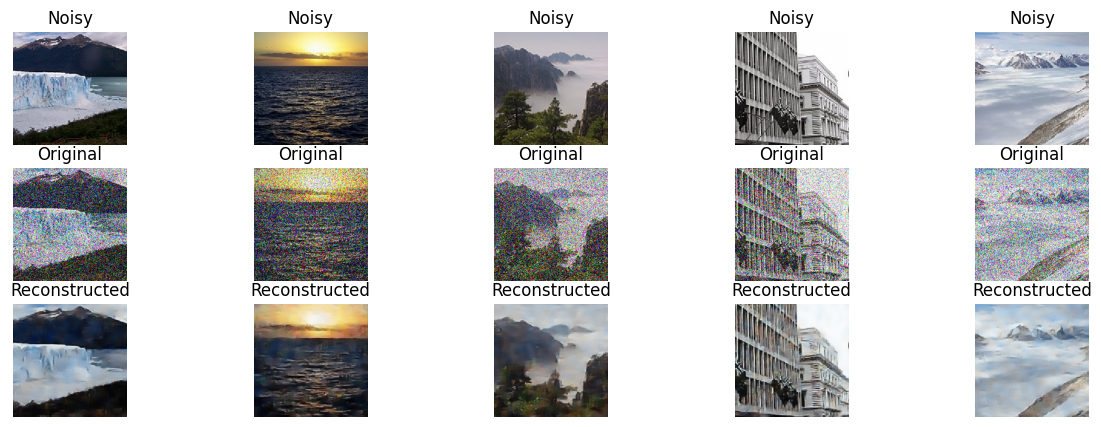

In [ ]:
# Отображаем изображения
display_images(o_images, n_images, r_images)

In [ ]:
metrics = model_rate(o_images, r_images)

mean_psnr = metrics['mean_psnr']
mean_ssim = metrics['mean_ssim']

print(f'Средний PNSR: {mean_psnr:.2f} дБ')
print(f'Средний SSIM: {mean_ssim:.4f}')

Средний PNSR: 22.45 дБ
Средний SSIM: 0.6216


Средний PNSR показывает удовлетворительное качество шума, шум частично удалён, но могут быть заметны артефакты. Средний SSIM демонстрирует неплохое сходство, структура изображения искажена на приемлемом уровне.

# 2. Автоэнкодер 2

## 2.1 Создание модели

In [ ]:
def create_autoencoder_2(input_shape):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2))(x)

    # Латентное пространство
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    # Декодер
    x = UpSampling2D(size=(2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, x)
    return autoencoder

In [ ]:
autoencoder = create_autoencoder_2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 224, 224, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_64               │ (None, 224, 224, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 224, 224, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_65               │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_64 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_66               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_67               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_28 (UpSampling2D)      │ (None, 224, 224, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 224, 224, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 224, 224, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 224, 224, 3)         │           3,459 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 340,803 (1.30 MB)

 Trainable params: 340,035 (1.30 MB)

 Non-trainable params: 768 (3.00 KB)

## 2.2 Обучение модели

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 133s 385ms/step - loss: 0.0157 - val_loss: 0.0180
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 356ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 356ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 357ms/step - loss: 0.0081 - val_loss: 0.0076
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 356ms/step - loss: 0.0079 - val_loss: 0.0074
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 357ms/step - loss: 0.0074 - val_loss: 0.0095
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 355ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 356ms/step - loss: 0.0070 - val_loss: 0.0071
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 142s 356ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 111s 355ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 143s 358ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 12

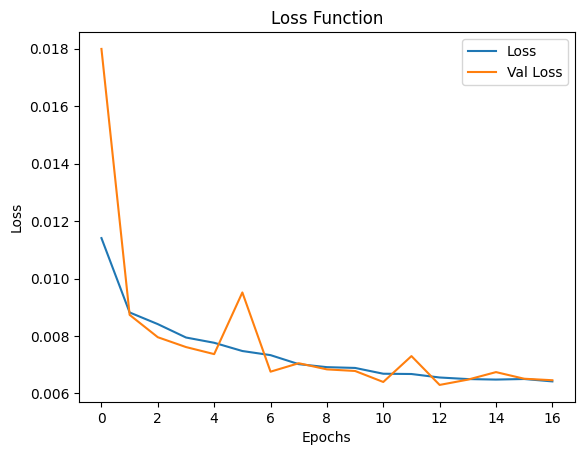

In [ ]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
history = autoencoder.fit(train_data, validation_data=val_data,
                          epochs=EPOCHS, batch_size=BATCH_SIZE,
                          callbacks=[early_stopping], verbose=1)

# Визуализация потерь
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
source_path = '/content/CV_2_2.keras'
autoencoder.save(source_path)

## 2.3 Тесты


In [ ]:
! gdown 1zwMBBX0d1xPZgxBHsJpTNWw3iZVFpYqd

Downloading...
From: https://drive.google.com/uc?id=1zwMBBX0d1xPZgxBHsJpTNWw3iZVFpYqd
To: /content/CV_2_2.keras
100% 4.16M/4.16M [00:00<00:00, 30.0MB/s]


In [ ]:
autoencoder = load_model('/content/CV_2_2.keras')

In [ ]:
o_images = []
n_images = []
r_images = []

for noisy_images, original_images in test_data:
    o_images.extend(original_images)
    #new_noisy_images = add_salt_pepper(noisy_images, 0.5)
    n_images.extend(noisy_images)
    r_images.extend(autoencoder.predict(noisy_images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

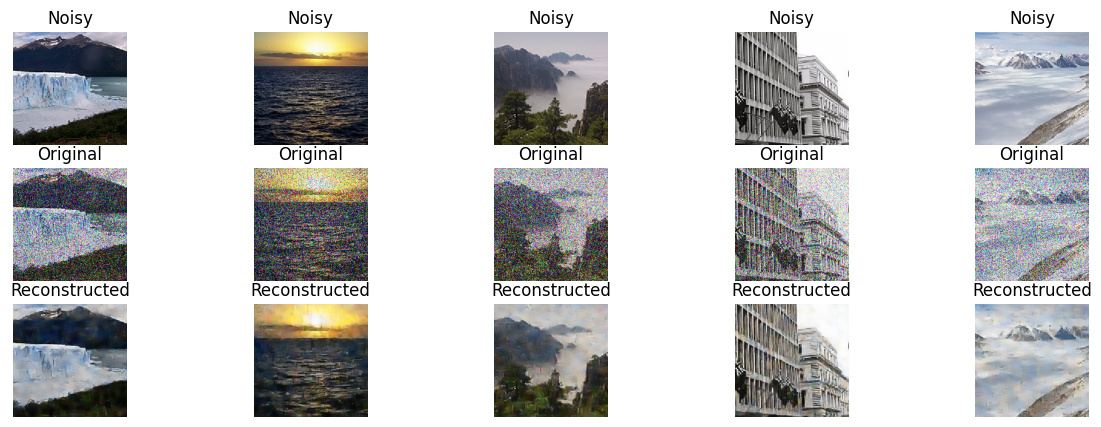

In [ ]:
# Отображаем изображения
display_images(o_images, n_images, r_images)

In [ ]:
metrics = model_rate(o_images, r_images)

mean_psnr = metrics['mean_psnr']
mean_ssim = metrics['mean_ssim']

print(f'Средний PNSR: {mean_psnr:.2f} дБ')
print(f'Средний SSIM: {mean_ssim:.4f}')

Средний PNSR: 22.35 дБ
Средний SSIM: 0.6182


Средний PNSR показывает удовлетворительное качество шума, шум частично удалён, но могут быть заметны артефакты. Средний SSIM демонстрирует неплохое сходство, структура изображения искажена на приемлемом уровне (чуть хуже предыдущей модели из-за меньшего количества слоёв свёртки).

# 3. Автоэнкодер 3

## 3.1 Создание модели

In [ ]:
def create_autoencoder_3(input_shape):
    input_img = Input(shape=input_shape)

    # Энкодер
    x = Conv2D(256, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Декодер
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) # Выход

    autoencoder = Model(input_img, x)
    autoencoder.summary()
    return autoencoder

In [ ]:
autoencoder = create_autoencoder_3(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 224, 224, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 224, 224, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_28 (ReLU)                      │ (None, 224, 224, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_60 (MaxPooling2D)      │ (None, 112, 112, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 112, 112, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_29 (ReLU)                      │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_61 (MaxPooling2D)      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 56, 56, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_30 (ReLU)                      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_62 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 28, 28, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_31 (ReLU)                      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_63 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_24 (UpSampling2D)      │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 801,987 (3.06 MB)

 Trainable params: 800,067 (3.05 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 3.2 Обучение модели

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 206s 562ms/step - loss: 0.0276 - val_loss: 0.0750
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 150s 481ms/step - loss: 0.0176 - val_loss: 0.0178
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 148s 475ms/step - loss: 0.0160 - val_loss: 0.0161
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 479ms/step - loss: 0.0150 - val_loss: 0.0184
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - loss: 0.0147 - val_loss: 0.0276
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 477ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 148s 476ms/step - loss: 0.0141 - val_loss: 0.0135
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 150s 479ms/step - loss: 0.0137 - val_loss: 0.0146
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 148s 474ms/step - loss: 0.0132 - val_loss: 0.0145
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 149s 476ms/step - loss: 0.0133 - val_loss: 0.0138


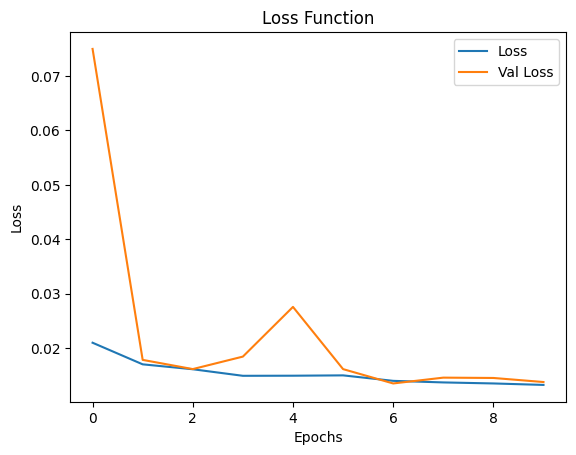

In [ ]:
# Обучение модели
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = autoencoder.fit(train_data, validation_data=val_data,
                          epochs=EPOCHS, batch_size=BATCH_SIZE,
                          callbacks=[early_stopping], verbose=1)

# Визуализация потерь
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
source_path = '/content/CV_2_3.keras'
autoencoder.save(source_path)

## 3.3 Тесты


In [ ]:
! gdown 1RN5ny5-ySRuIM1Y6ETMjQJz3eg58wO7l

Downloading...
From (original): https://drive.google.com/uc?id=1Fh6g2MxHAuU1kS6DZFZqiV_Hmm87J0bg
From (redirected): https://drive.google.com/uc?id=1Fh6g2MxHAuU1kS6DZFZqiV_Hmm87J0bg&confirm=t&uuid=8e39b0ba-58e3-4a8b-a91b-ea9a56270c66
To: /content/CV_2_3.keras
100% 43.5M/43.5M [00:01<00:00, 27.2MB/s]


In [ ]:
autoencoder = load_model('/content/CV_2_3.keras')

In [ ]:
o_images = []
n_images = []
r_images = []

for noisy_images, original_images in test_data:
    o_images.extend(original_images)
    #new_noisy_images = add_salt_pepper(noisy_images, 0.5)
    n_images.extend(noisy_images)
    r_images.extend(autoencoder.predict(noisy_images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

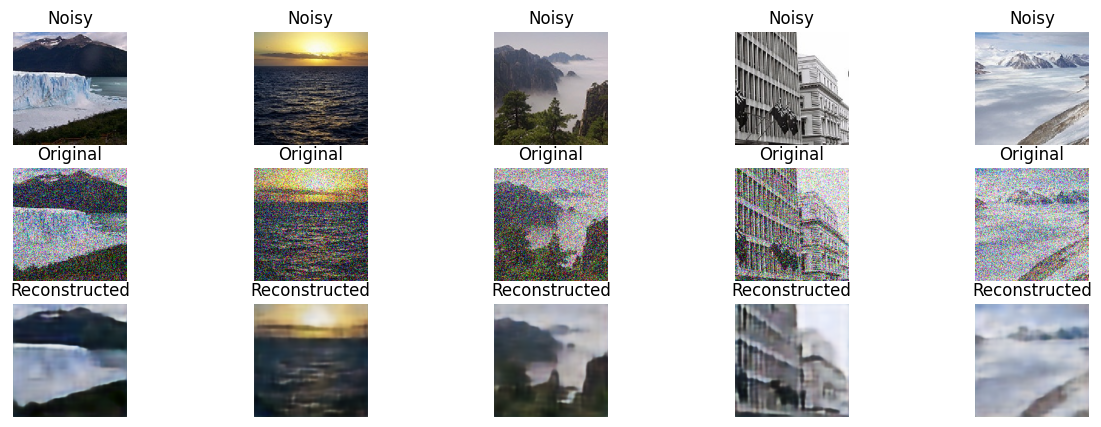

In [ ]:
# Отображаем изображения
display_images(o_images, n_images, r_images)

In [ ]:
metrics = model_rate(o_images, r_images)

mean_psnr = metrics['mean_psnr']
mean_ssim = metrics['mean_ssim']

print(f'Средний PNSR: {mean_psnr:.2f} дБ')
print(f'Средний SSIM: {mean_ssim:.4f}')

Средний PNSR: 19.35 дБ
Средний SSIM: 0.4172


Средний PNSR показывает низкое качество шума, шум плохо удалён, могут быть заметны артефакты. Средний SSIM демонстрирует низкое сходство, структура изображения сильно искажена.



# Вывод

Для эффективного удаления шума с изображений с помощью автоэнкодеров важно учитывать баланс между качеством (метрики PSNR, SSIM) и вычислительной эффективностью.

*   Autoencoder 1 показывает лучшие результаты по SSIM за счёт глубокой архитектуры, однако является избыточным в масштабах поставленной задачи.
*   Autoencoder 2 менее сложный, работает быстрее и при этом теряет в качестве восстановления незначительно, что даёт значительный прирост в плане скорости обработки. Такой компромисс можно считать оптимальным.
*   Из-за адаптации архитектуры SegNet под задачу удаления шума модель показала себя хуже остальных, что делает её менее подходящей для данной задачи.

Для оптимального решения можно:

*   Добавить skip-connections для сохранения деталей.
*   Усилить Autoencoder 1, добавив несколько слоёв Conv2D (32 фильтра), а также по одному MaxPooling и UpSampling (2×2) для лучшей реконструкции изображения.
*   Использовать сверточные автоэнкодеры, глубокие автоэнкодеры или регуляризацию для повышения устойчивости к шумам.